# Simple power spectrum estimation from an input dataset
This example shows how to estimate the power spectrum from a set of data files using an Optimal Quadratic Estimator (OQE) approach.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

## Loading the input data: form pspectra from adjacent time integrations

The input data are specified as a list of `UVData` objects, which are then packaged into a `PSpecData` class. This class is responsible for collecting the data and covariances together and performing the OQE power spectrum estimation.

At least two `UVData` objects must be specified, these could be different datasets, or just copies of a single dataset, given the use-case. In what follows, we will use only one data set and produce two copies of it, but will shift the second dataset by one time integration and interleave it relative to the first, such that we can form auto-baseline power spectra without noise-bias. 

In [2]:
# Instantiate a Cosmo Conversions object
cosmo = hp.conversions.Cosmo_Conversions()
print cosmo

Cosmo_Conversions object at <0x11dedf410>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [3]:
# List of filenames of the data to load
dfile = '../hera_pspec/data/zen.all.xx.LST.1.06964.uvA'
beamfile = '../hera_pspec/data/NF_HERA_Beams.beamfits'
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Load into UVData objects
uvd = UVData()
uvd.read_miriad(dfile)

# Check which baselines are available
print(uvd.get_antpairs())

[(24, 24), (24, 25), (24, 37), (24, 38), (24, 39), (25, 25), (25, 37), (25, 38), (25, 39), (37, 37), (37, 38), (37, 39), (38, 38), (38, 39), (39, 39)]


In [4]:
# convert from Jy to mK
uvd.data_array *= uvb.Jy_to_mK(np.unique(uvd.freq_array))[None, None, :, None]
uvd.vis_units = "mK"

In [5]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

## Phase second `dset` to first `dset`

Because we are forming power spectra between datasets that are offset in LST there will be some level of decoherence (and therefore signal loss) of the EoR signal. For short baselines and small LST offsets this is typically negligible, but it is still good to try to recover what coherency we can, simply by phasing (i.e. fringe-stopping) the datasets before forming the power spectra. This can be done with the `rephase_to_dset` method, and can only be done once. 

In [6]:
# Because the LST integrations are offset by more than a few seconds 
# just because of the test-file we are using, we will get a warning.

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)

## Estimating the power spectrum for a handful of baseline pairs (auto-baseline pspec)
Estimate the power spectrum for a handful baseline pairs between the two datasets in `ds.dsets`. You can specify which baselines are included in the power spectrum estimate, which datasets to use, what freq channels to use, and how the estimate should be weighted.

The result is a `UVPSpec` object that holds all of the power spectra and their meta-data.

In [7]:
# Specify which baselines to include
bls = [(24,25), (37,38), (38,39)]

# Calculate the power spectrum using: 
# bls list for bls1 and bls list for bls2
# datasets 0 for bls1 and 1 for bls2
# spectral range selection
# identity weighting
# blackman-harris tapering func
uvp = ds.pspec(bls, bls, (0, 1), spw_ranges=[(300, 400), (600,721)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...



## Making sense of the meta-data

The fundamental unit in the `UVPSpec` object is a single delay spectrum, indexed by a spectral window selection (`spw`), a baseline-pair selection (`blpair`) and a polarization (`pol`). Spectral windows are marked by their index (see `spw_array`), polarization are marked by their pol string (`xx`) or pol integer (`-5`), and a baseline-pair is marked by its blpair integer, which is simply the antenna numbers put into length-3 integers and concatenated. For example, the baseline-pair `((100, 200), (300, 400))` would have a blpair integer `100200300400`.

There is also information telling you things like the data weighting, normalization, tapering, units, telescope location, LST and JD time stamps, etc.

Although not technically considered meta-data, there is also information on the amount of time-integration that went into every power spectra in the `integrations_array` attribute.

To access particular slices of the data in a `UVPSpec` object, the user should interface with the `get_data` method, which takes a selection of `spw`, `blpair` and `pol` as arguments. See the example below.

In [8]:
# let's get the delay spectra from spw 0, blpair ((24, 25), (24, 25)) and xx pol
key = (0, ((24, 25), (24, 25)), 'xx')

# output should be shape (Ntimes, Ndlys)
print "spw 0 data shape = (Ntimes, Ndlys): ",uvp.get_data(key).shape

# get power spectrum units
print "pspec units: ",uvp.units

spw 0 data shape = (Ntimes, Ndlys):  (3, 100)
pspec units:  (mK)^2 h^-3 Mpc^3


## Plotting

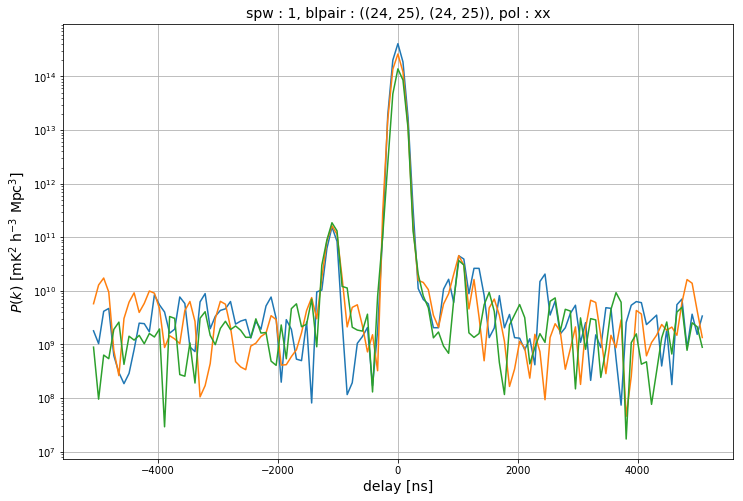

In [9]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (24,25))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Use redundant baseline grouping (auto & cross baseline pspec)

You can also feed `pspec` a list of redundant baseline groups and it will compute all cross spectra in each group.

In [10]:
# bls is now a list of lists
bls = [[(24,25), (37,38), (38,39)]]

# Calculate the power spectrum using: 
# bls list for bls1 and bls list for bls2
# datasets 0 for bls1 and 1 for bls2
# spectral range of selection
# identity weighting
# blackman-harris tapering func
uvp = ds.pspec(bls, bls, (0, 1), spw_ranges=[(300, 400), (600,721)], input_data_weight='identity', norm='I', 
               taper='blackman-harris', verbose=True)


Setting spectral range: (300, 400)

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (37, 38))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 25), (38, 39))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (24, 25))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: XX
  Setting weight matrix for input data...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (38, 39))
pol: XX
  Sett

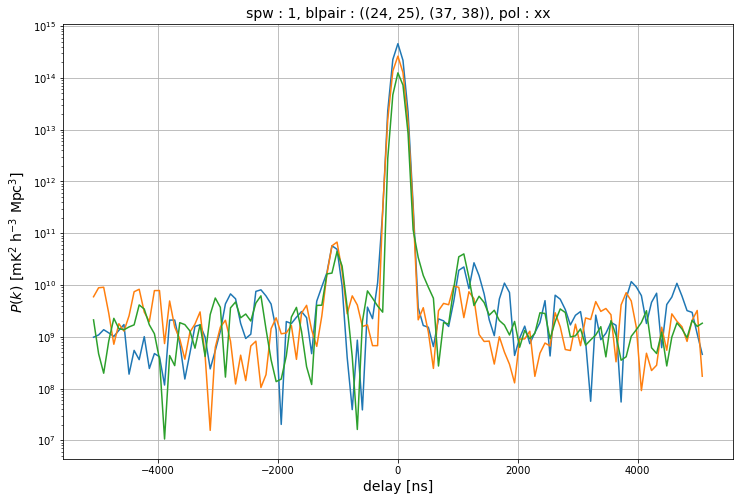

In [11]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

_ = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

### Convert to $\Delta^2(k)$

You can convert the power spectrum data from $P(k)$ format to "unitless" power spectrum $\Delta^2(k)$ by scaling by the cosmological wave-vectors cubed. This can be done by hand with the `get_kvecs()` method, or can be done automatically using the `convert_to_deltasq()` method.

If properly normalized, `UVPSpec` will have a `cosmo_params` list that contains the cosmological parameters used to normalized the power spectra. You can add these parameters to the `UVPSpec.cosmo` object using the `add_cosmology` method.

In [12]:
# add the cosmological parameters to uvp
print uvp.cosmo_params

print '--'*30
uvp.add_cosmology(uvp.cosmo_params)

{'H0': 67.27, 'Om_k': 0.0020700000000000163, 'Om_M': 0.31353, 'Om_L': 0.6844, 'Om_c': 0.26442, 'Om_b': 0.04911}
------------------------------------------------------------
attaching cosmology: 
Cosmo_Conversions object at <0x122b87a50>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [13]:
# get wave vectors for plotting
dsq = copy.deepcopy(uvp)
k_perp, k_para = dsq.get_kvecs(1, little_h=True)

# convert to deltasq
dsq.convert_to_deltasq()

print "dsq units: ",dsq.units

dsq units:  (mK)^2 h^-3 Mpc^3 h^3 k^3 / (2pi^2)


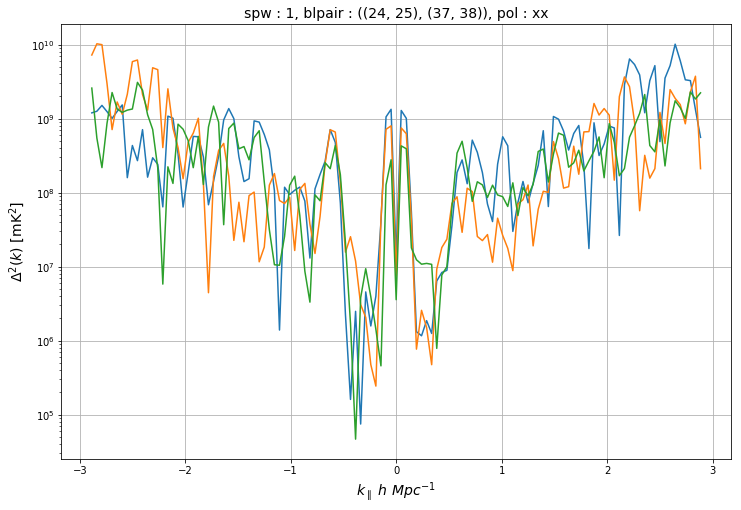

In [14]:
# plot deltasq power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
key = (spw, blp, 'xx')
power = np.abs(np.real(dsq.get_data(key)))

_ = ax.plot(k_para, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_{\parallel}\ h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$\Delta^2(k)\ \rm [mK^2]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

## Plotting Thermal Noise Curves

Using the `hera_pspec.noise` module, you can plot analytic thermal noise power spectra given a $T_{\rm sys}$ and the `integration_array` and `nsample_array` found in the `UVPSpec` object.

To do this, you need to first instantiate a `noise.Sense` object using the `UVPSpec.generate_sense()` method. This takes a `pspecbeam.PSpecBeam` object, which we saw before when using `PSpecData` objects. We have already attached a `cosmo` object to `uvp`, so it will automatically use that for the cosmology.

In [15]:
uvp.generate_sensitivity(uvb)

attaching self.sensitivity


Have generated the `Sense` object, we can now call `generate_noise_spectra` to produce noise curves.

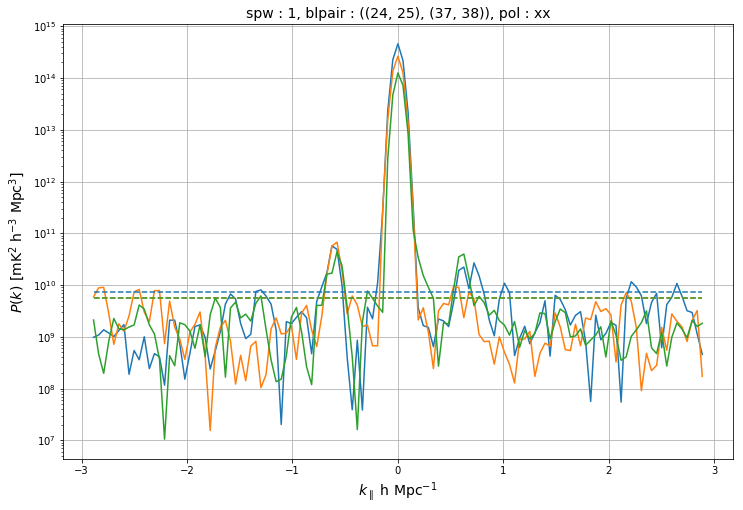

In [16]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (37, 38))
key = (spw, blp, 'xx')
k_perp, k_para = uvp.get_kvecs(spw)
power = np.abs(np.real(uvp.get_data(key)))

P_N = uvp.generate_noise_spectra(spw, 'xx', 400)
P_N = P_N[uvp.blpair_to_indices(blp)]

_ = ax.plot(k_para, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N.T, ls='--')

## Incoherent Averaging

The `UVPSpec` object supports incoherent averaging across baseline-pairs and/or time using the `UVPSpec.average_blpairs()` method. If the baseline-pairs are grouped by redundancy, this is equivalent to binning onto a single 3D $k_x, k_y, k_\parallel$ space. If the baseline-pairs are grouped by baseline separation, this is equivalent to cylindrical binning in $k_\perp$ and $k_\parallel$. Spherical binning to form a true 1D power spectrum is currently not supported.

Below we will incoherently average across all baseline-pairs in the `UVPSpec` object, knowing that we only constructed 14.6 m power spectra, so we are reasonably justified in doing so.

In [17]:
blp_group = [sorted(np.unique(uvp.blpair_array))]
uvp2 = uvp.average_spectra(blpair_groups=blp_group, time_avg=True, inplace=False)

We can then plot the averaged power spectrum, along with the noise curve which will know to account for the averaging based on the changes to the `integration_array` and `nsample_array`. The colored lines show the same un-averaged pspectra from before, while the black line shows the averaged power spectrum, along with its thermal noise estimate.

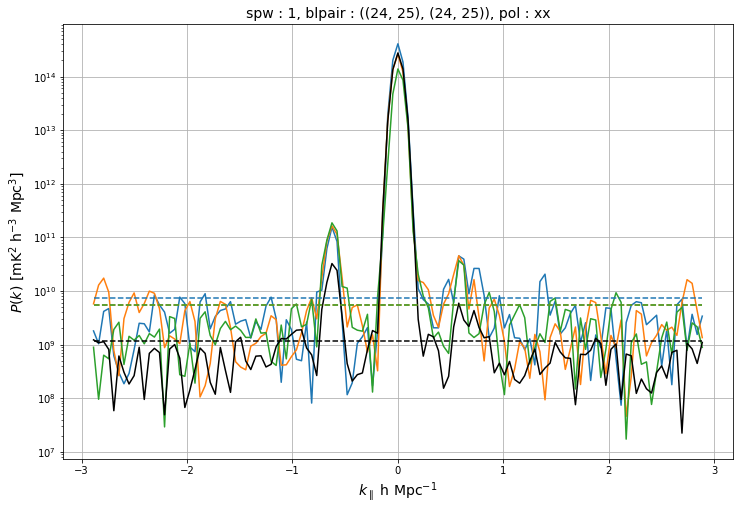

In [18]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (24, 25))
key = (spw, blp, 'xx')
k_perp, k_para = uvp.get_kvecs(spw)
power = np.abs(np.real(uvp.get_data(key)))
P_N = uvp.generate_noise_spectra(spw, 'xx', 400)
P_N = P_N[uvp.blpair_to_indices(blp)]

spw = 1
blp =((24, 25), (24, 25))
key = (spw, blp, 'xx')
avg_power = np.abs(np.real(uvp2.get_data(key)))
avg_P_N = uvp2.generate_noise_spectra(spw, 'xx', 400)
avg_P_N = avg_P_N[uvp2.blpair_to_indices(blp)]

_ = ax.plot(k_para, power.T)
ax.plot(k_para, avg_power.T, color='k')
ax.plot(k_para, avg_P_N.T, color='k', ls='--')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N.T, ls='--')

## Fold the power spectra

The power spectra are natively across positive and negative delays, but often we make plots with only positive delay bins. In addition, averaging bandpowers with identical negative with positive bandpowers gives us an extra factor of sqrt 2 sensitivity, which we can do with the `fold_spectra()` method.

In [19]:
uvp.fold_spectra()

In [20]:
uvp2.fold_spectra()

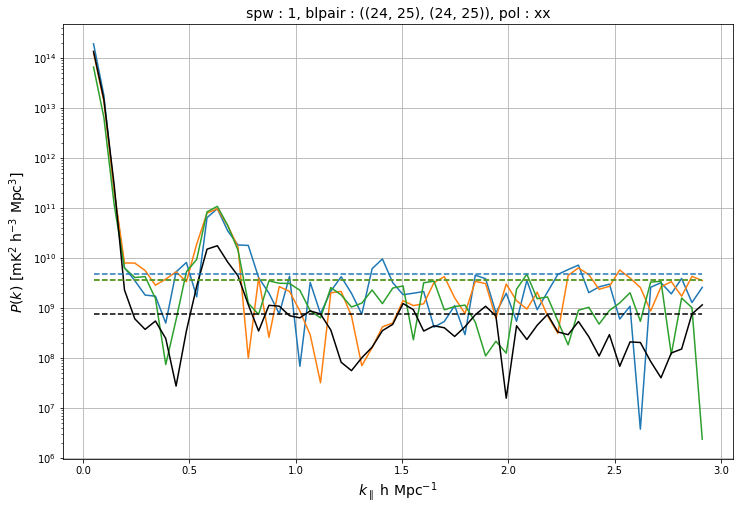

In [21]:
# plot power spectrum of spw 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 1
blp =((24, 25), (24, 25))
key = (spw, blp, 'xx')
k_perp, k_para = uvp.get_kvecs(spw)
power = np.abs(np.real(uvp.get_data(key)))
P_N = uvp.generate_noise_spectra(spw, 'xx', 400)
P_N = P_N[uvp.blpair_to_indices(blp)]

spw = 1
blp =((24, 25), (24, 25))
key = (spw, blp, 'xx')
avg_power = np.abs(np.real(uvp2.get_data(key)))
avg_P_N = uvp2.generate_noise_spectra(spw, 'xx', 400)
avg_P_N = avg_P_N[uvp2.blpair_to_indices(blp)]

_ = ax.plot(k_para, power.T)
ax.plot(k_para, avg_power.T, color='k')
ax.plot(k_para, avg_P_N.T, color='k', ls='--')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

ax.set_prop_cycle(None)
_ = ax.plot(k_para, P_N.T, ls='--')

## Select parts of the data to keep

We can select out parts of the data using the `select` function. Currently we only support selecting out spectral windows, baseline pairs and times.

In [22]:
# select out all baseline-pairs containing the baseline (24, 25)
# only_pairs_in_bls means to select only blpairs that have baseline1 _and_ baseline2 in the bls list
uvp2 = uvp.select(bls=[(24, 25)], inplace=False, only_pairs_in_bls=False)

print "baseline pairs in uvp2: \n", map(lambda blp: uvp2.blpair_to_antnums(blp), np.unique(uvp2.blpair_array))

baseline pairs in uvp2: 
[((24, 25), (24, 25)), ((24, 25), (37, 38)), ((24, 25), (38, 39)), ((37, 38), (24, 25)), ((38, 39), (24, 25))]


## Write to HDF5

Using the `write_hdf5` method.

In [23]:
uvp.write_hdf5("pspec.hdf5", overwrite=True)

## Read from HDF5

Read the whole file, just the meta-data, or a data selection for partial I/O.

Read the whole file and look at some meta-data.

In [24]:
# read the whole file
uvp2 = hp.uvpspec.UVPSpec()
uvp2.read_hdf5("pspec.hdf5")

# print some meta-data
print "pols : ", uvp2.pol_array
print "number of baseline-pairs: ",uvp2.Nblpairs

# Ensure data_array exists
print "data_array in uvp2 : ", hasattr(uvp2, 'data_array')

pols :  [-5]
number of baseline-pairs:  9
data_array in uvp2 :  True


Now read only the meta-data.

In [25]:
# read only the meta-data
uvp2.read_hdf5("pspec.hdf5", just_meta=True)

# print some meta-data
print "pols : ", uvp2.pol_array
print "number of baseline-pairs: ",uvp2.Nblpairs

# Ensure data_array doesn't exist (b/c we only loaded the meta-data)
print "data_array in uvp2 : ", hasattr(uvp2, 'data_array')

pols :  [-5]
number of baseline-pairs:  9
data_array in uvp2 :  False


Now do partial loading of baseline pairs.

In [26]:
# read metadata and data, but only part of the file (a single baseline pair)
# bls is the baselines you want to load in, and only_pairs_in_bls=True means both the
# first _and_ second baseline in a baseline-pair must bbe in the bls list.
uvp2.read_hdf5("pspec.hdf5", just_meta=False, bls=[(24, 25)], only_pairs_in_bls=True)

# print some meta-data
print "pols : ", uvp2.pol_array
print "number of baseline-pairs: ",uvp2.Nblpairs

# Ensure data_array doesn't exist (b/c we only loaded the meta-data)
print "data_array in uvp2 : ", hasattr(uvp2, 'data_array')

# print baseline pairs
print "baseline pairs in uvp2: \n", map(lambda blp: uvp2.blpair_to_antnums(blp), np.unique(uvp2.blpair_array))

pols :  [-5]
number of baseline-pairs:  1
data_array in uvp2 :  True
baseline pairs in uvp2: 
[((24, 25), (24, 25))]


Now do partial loading of times. To do this, we need to feed the exact float entries of the `time_avg_array` we want. But how do we get these without loading the whole file to begin with? That's where a practical application of the `just_meta` keyword comes in. First we will load only the meta-data, and then feed the `read_hdf5` method with the times that we want.

In [27]:
# read only meta
uvp2.read_hdf5("pspec.hdf5", just_meta=True)

# now only load in one of the time integrations
uvp2.read_hdf5("pspec.hdf5", times=np.unique(uvp2.time_avg_array)[:1])

# check that only one time integration exists, but that all baseline pairs exist
print "number of unique times: ", len(np.unique(uvp2.time_avg_array))
print "number of baseline-pairs: ",uvp2.Nblpairs

number of unique times:  1
number of baseline-pairs:  9


In [28]:
if os.path.exists("pspec.hdf5"): os.remove("pspec.hdf5")